In [1]:
# define libraries to use
import pandas as pd
import numpy as np
#from pathlib import Path
import requests,json
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import scipy as sp
%matplotlib inline
import pickle
import seaborn as sns
from tabulate import tabulate

pd.options.display.max_columns = None
pd.options.display.max_rows = 50

def millions(x,pos=0):
    if x==0:
        return '0'
    else:
        return '%1.1fM' % (float(x) * 1e-6)

# Plot Pie but group categories below threhold
def PlotPie(df, catDict, title, minThr = 0, printTable = True, ax=None):
    serToPlot = df.value_counts().rename(catDict)
    if printTable:
        print(tabulate(pd.DataFrame(serToPlot)))
    if minThr > 0:
        theTotal = serToPlot.sum()
        serToPlot = serToPlot[serToPlot/theTotal >= minThr]
        serToPlot["Other"] = theTotal - serToPlot.sum()
    return serToPlot.plot.pie(legend = False, title = title, ylabel = "", autopct="%1.1f%%", pctdistance = 0.7, rotatelabels = False, ax=ax)


# Plot Horizontal Bar graph but group categories below threhold
def PlotBarh(df, catDict, title, minThr = 0, printTable = True, ax=None):
    serToPlot = df.value_counts().rename(catDict)
    if printTable:
        print(tabulate(pd.DataFrame(serToPlot)))
    if minThr > 0 and minThr <=1:
        theTotal = serToPlot.sum()
        serToPlot = serToPlot[serToPlot/theTotal >= minThr]
        serToPlot["Other"] = theTotal - serToPlot.sum()
    elif minThr > 1:
        theTotal = serToPlot.sum()
        serToPlot = serToPlot.head(min(minThr,len(serToPlot)))
        serToPlot["Other"] = theTotal - serToPlot.sum()
    return serToPlot.plot.barh(title = title,ax=ax)



In [2]:
safetyFeaturesColumns = [
 	"ForwardCollisionWarningId",
	"DynamicBrakeSupportId",
	"CrashImminentBrakingID",
	"PedestrianAutoEmergencyBrakingId",
	"BlindSpotWarningId",
	"BlindSpotInterventionId",
	"LaneDepartureWarningId",
	"LaneKeepingAssistanceId",
	"LaneCenteringAssistanceId",
	#"BackupCameraId",
	"RearCrossTrafficAlertId",
	"RearAutomaticEmergencyBrakingId",
	"ParkAssistId",
	"DaytimeRunningLightId",
	#"HeadlampLightSourceId",
	"SemiAutoHeadlampBeamSwitchingId",
	"AdaptiveDrivingBeamId",
	"AdaptiveCruiseControlId",
	"AntilockBrakeSystemId",
	"ElectronicStabilityControlId",
	"TPMSId",
	"TractionControlId",
	"AutoPedestrianAlertingSoundId",
]

safetyFeaturesNames = {
 	"ForwardCollisionWarningId" : "Forward Collision Warning",
	"DynamicBrakeSupportId" : "Dynamic Brake Support",
	"CrashImminentBrakingID" : "Crash Imminent Braking",
	"PedestrianAutoEmergencyBrakingId" : "Pedestrian Auto Emergency Braking",
	"BlindSpotWarningId" : "Blind Spot Warning",
	"BlindSpotInterventionId": "Blind Spot Intervention",
	"LaneDepartureWarningId" : "Lane Departure Warning",
	"LaneKeepingAssistanceId" : "Lane Keeping Assistance",
	"LaneCenteringAssistanceId" : "Lane Centering Assistance",
	"BackupCameraId" : "Backup Camera",
	"RearCrossTrafficAlertId" : "Rear Cross Traffic Alert",
	"RearAutomaticEmergencyBrakingId" : "Rear Automatic Emergency Braking",
	"ParkAssistId" : "Park Assist",
	"DaytimeRunningLightId" : "Daytime Running Light",
	#"HeadlampLightSourceId",
	"SemiAutoHeadlampBeamSwitchingId" : "Semi Auto Headlamp Beam Switching",
	"AdaptiveDrivingBeamId" : "Adaptive Driving Beam",
	"AdaptiveCruiseControlId" : "Adaptive Cruise Control",
	"AntilockBrakeSystemId" : "Antilock Brake System",
	"ElectronicStabilityControlId" : "Electronic Stability Control",
	"TPMSId" : "Tire Pressure Monitoring System",
	"TractionControlId" : "Traction Control",
	"AutoPedestrianAlertingSoundId" : "Auto Pedestrian Alerting Sound",
}

def AnyStdSafetyFeature(vpicRow):
	"""Returns true if any of the safety features are marked standard for the vehicle checked 
	(vpicdecode columnnames are used)attribute value = 1 means standard
	"""
	
	stdFeatureFlag = False
	for feat in safetyFeaturesColumns:
		if feat in vpicRow.index:
			stdFeatureFlag = stdFeatureFlag | (vpicRow[feat] == 1)
	return stdFeatureFlag

In [3]:
nydmvModelIDCat = pd.read_pickle("tmp/nydmv-vindecode-modelid-dict.pkl")
nydmvMakeIDCat = pd.read_pickle("tmp/nydmv-vindecode-makeid-dict.pkl")

In [4]:
nydmvVinDecodeDf = pd.read_pickle("tmp/nydmv-vindecodedf.pkl")
nydmvVinDecodeDf.set_index("entry",inplace=True)
nydmvDf = pd.read_pickle("tmp/nydmvdf.pkl")
nydmvVinDecodeDf = pd.merge(nydmvDf,nydmvVinDecodeDf,left_index=True, right_index=True)
nydmvDf = None
nydmvVinDecodeDf.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11180719 entries, 33 to 12586465
Data columns (total 55 columns):
 #   Column                            Non-Null Count     Dtype         
---  ------                            --------------     -----         
 0   VIN                               11180719 non-null  object        
 1   Registration Class                11180719 non-null  category      
 2   City                              11180719 non-null  object        
 3   State                             11180719 non-null  category      
 4   Zip                               11180719 non-null  category      
 5   County                            11180719 non-null  object        
 6   Model Year                        11180719 non-null  Int64         
 7   Make                              11180719 non-null  category      
 8   Body Type                         11180719 non-null  category      
 9   Fuel Type                         11180719 non-null  category      
 10  Unl

In [5]:
# FAR categories dictionary, reused for some of the VPIC-related fields
f = open("tmp/fars-categories.pkl","rb")
farsCategories = pickle.load(f)
f.close()

In [6]:
# add anysafetyfeature flag
#nydmvVinDecodeDf["AnySafetyFeature"] = nydmvVinDecodeDf.apply(lambda row: AnyStdSafetyFeature(row),axis=1)
print(nydmvVinDecodeDf["AnySafetyFeature"].sum(),"vehicles with at least one safety feature.")

7657277 vehicles with at least one safety feature.


-----------------------------------------------------------  ----------------
TOYOTA                                                            1.28638e+06
HONDA                                                             1.23386e+06
FORD                                                              1.16798e+06
CHEVROLET                                                         1.16439e+06
NISSAN                                                       686714
JEEP                                                         607621
SUBARU                                                       510729
HYUNDAI                                                      411982
DODGE                                                        306439
BMW                                                          289671
GMC                                                          274414
MERCEDES-BENZ                                                268919
KIA                                                          25253

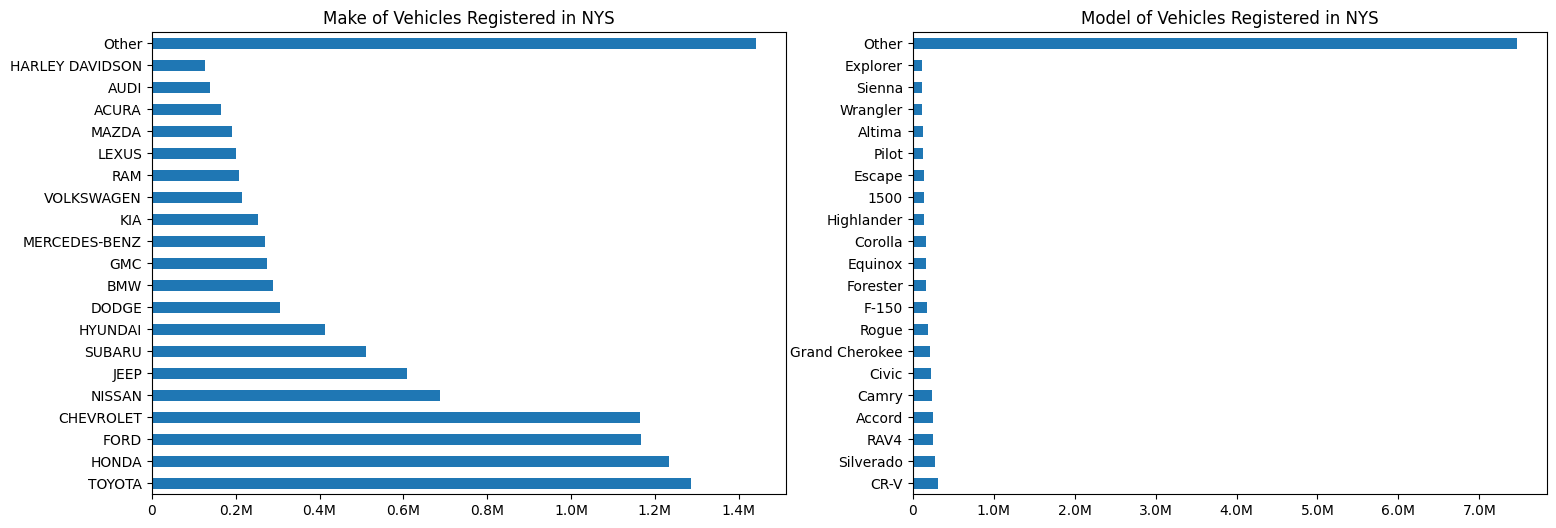

In [7]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,6))

_ = PlotBarh(nydmvVinDecodeDf["MakeID"],nydmvMakeIDCat,"Make of Vehicles Registered in NYS",20,ax=ax[0])
ax[0].xaxis.set_major_formatter(ticker.FuncFormatter(millions))

_ = PlotBarh(nydmvVinDecodeDf["ModelID"],nydmvModelIDCat,"Model of Vehicles Registered in NYS",20,ax=ax[1])
ax[1].xaxis.set_major_formatter(ticker.FuncFormatter(millions))

NYS Mode Year mean   = 2014
NYS Mode Year median = 2015
NYS Mode Year mode   = 2019.0


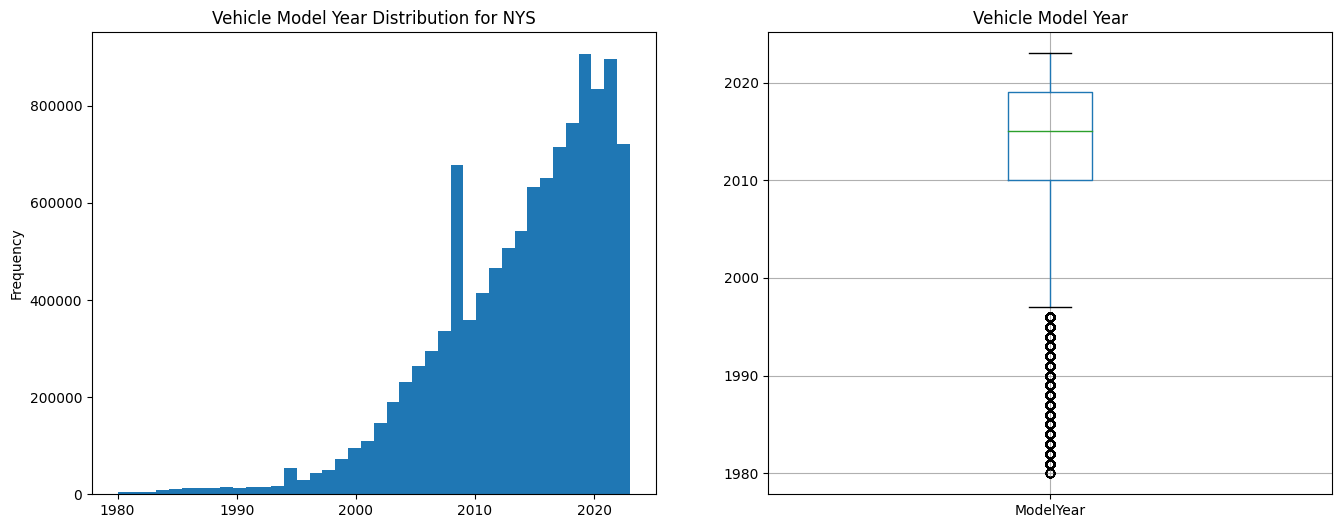

In [8]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,6))

_ = nydmvVinDecodeDf[nydmvVinDecodeDf["ModelYear"] < 9998]["ModelYear"].plot.hist(bins=40,title="Vehicle Model Year Distribution for NYS",ax=ax[0])

nydmvVinDecodeDf[nydmvVinDecodeDf["ModelYear"] < 9998].boxplot(column="ModelYear", ax=ax[1])
ax[1].set_title("Vehicle Model Year")

print("NYS Mode Year mean   =",round(nydmvVinDecodeDf[nydmvVinDecodeDf["ModelYear"] < 9998]["ModelYear"].mean()))
print("NYS Mode Year median =",round(nydmvVinDecodeDf[nydmvVinDecodeDf["ModelYear"] < 9998]["ModelYear"].median()))
print("NYS Mode Year mode   =",nydmvVinDecodeDf[nydmvVinDecodeDf["ModelYear"] < 9998]["ModelYear"].mode()[0])

outmin = 1996.5 outmax = 2032.5 q1= 2010.0 q3= 2019.0


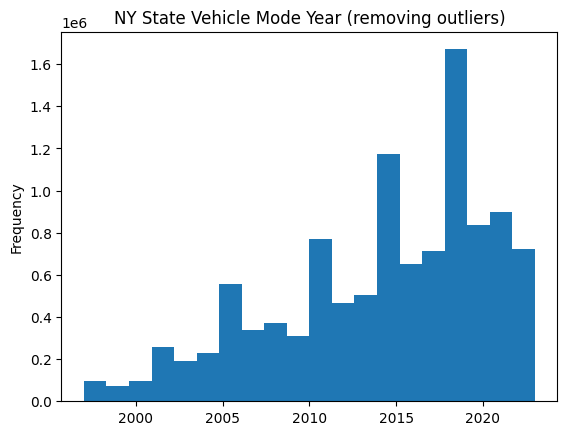

In [14]:
x = nydmvVinDecodeDf["ModelYear"]
q1 = x.quantile(.25)
q3 = x.quantile(.75)
IQR = q3 - q1
outmin = q1 - 1.5*IQR
outmax = q3 + 1.5*IQR

x = x[x.between(outmin, outmax)]
ax = x.plot.hist(bins=20,title="NY State Vehicle Mode Year (removing outliers)")
print("outmin =",outmin,"outmax =",outmax,"q1=",q1,"q3=", q3)

---------------------------------------------------------------------------  ----------------
Sport Utility Vehicle (SUV)/Multi-Purpose Vehicle (MPV)                           4.59896e+06
Sedan/Saloon                                                                      2.71222e+06
Pickup                                                                            1.24767e+06
Hatchback/Liftback/Notchback                                                 397826
Minivan                                                                      389401
Coupe                                                                        220741
Cargo Van                                                                    200421
Crossover Utility Vehicle (CUV)                                              189780
Convertible/Cabriolet                                                        145431
Truck                                                                        129640
Wagon                               

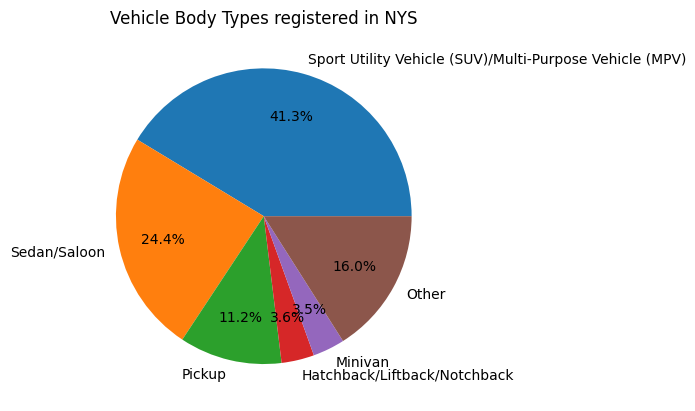

In [9]:
# Vehicle Body class
_ = PlotPie(nydmvVinDecodeDf["BodyClassId"],farsCategories["VPICBODYCLASS"],"Vehicle Body Types registered in NYS",0.034)

In [10]:
nydmvSafetyYrDf = nydmvVinDecodeDf[["ModelYear","AnySafetyFeature"]].groupby("ModelYear").agg(['count','sum'])
nydmvSafetyYrDf = nydmvSafetyYrDf["AnySafetyFeature"]
nydmvSafetyYrDf.columns = ["Total Cars","Cars with Safey Features"]
nydmvSafetyYrDf.index = nydmvSafetyYrDf.index.astype("int64")
nydmvSafetyYrDf.info(verbose=True,show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44 entries, 1980 to 2023
Data columns (total 2 columns):
 #   Column                    Non-Null Count  Dtype
---  ------                    --------------  -----
 0   Total Cars                44 non-null     int64
 1   Cars with Safey Features  44 non-null     int64
dtypes: int64(2)
memory usage: 1.0 KB


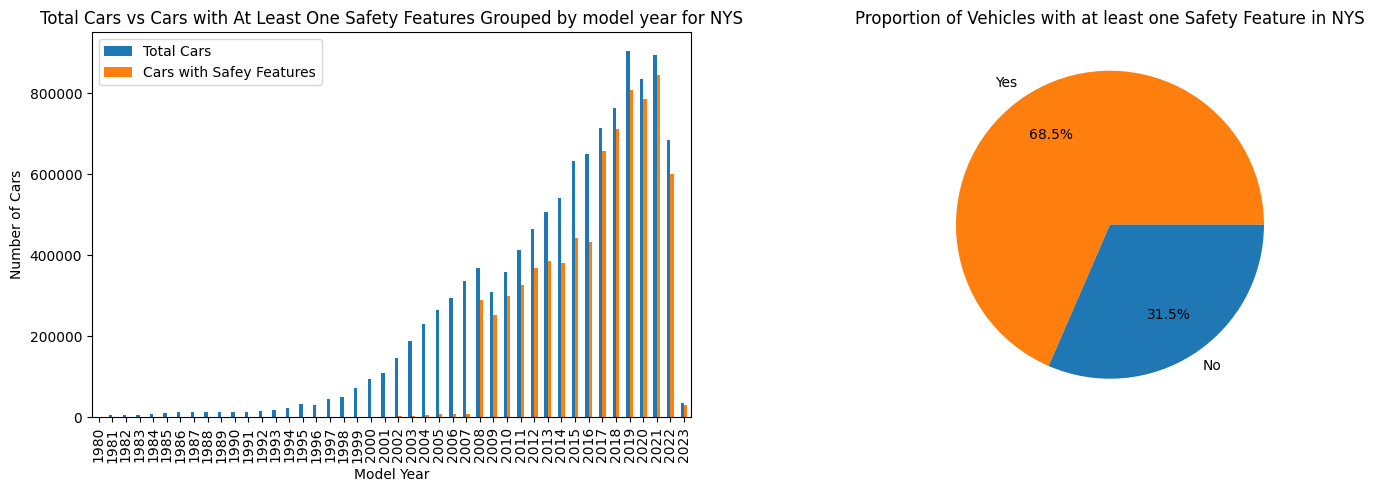

In [11]:
fig = plt.figure(figsize=(17,5))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
nydmvSafetyYrDf.plot.bar(stacked=False,ax=ax1,color=["tab:blue","tab:orange"])
ax1.set_xlabel("Model Year")
ax1.set_ylabel("Number of Cars")
ax1.set_title("Total Cars vs Cars with At Least One Safety Features Grouped by model year for NYS")
nydmvVinDecodeDf["AnySafetyFeature"].value_counts().rename({True:"Yes", False:"No"}).plot.pie(legend = False, \
    ylabel = "", autopct="%1.1f%%", pctdistance = 0.7, rotatelabels = False, ax=ax2, colors=["tab:orange","tab:blue"])
_ = ax2.set_title("Proportion of Vehicles with at least one Safety Feature in NYS")

In [12]:
totalVeh = len(nydmvVinDecodeDf)
tempDf = nydmvVinDecodeDf[safetyFeaturesColumns].fillna(int(0))
vehSafetyFeaturesCnt = pd.Series(dtype='float64')
print("check values for every safety feature")
for x in tempDf.columns.sort_values():
    vehSafetyFeaturesCnt[safetyFeaturesNames[x]] = (tempDf[x] == 1).sum()/totalVeh*100
    print(x.ljust(max([len(x) for x in tempDf.columns])+2),"\t",str(tempDf[x].drop_duplicates().sort_values().values).ljust(16),(tempDf[x] == 1).sum())
tempDf = None
vehSafetyFeaturesCnt.sort_values(inplace=True)
vehSafetyFeaturesCnt

check values for every safety feature
AdaptiveCruiseControlId            	 [0. 1. 2. 3.]    1372225
AdaptiveDrivingBeamId              	 [0. 1. 2. 3.]    897612
AntilockBrakeSystemId              	 [0. 1. 2. 3.]    3985918
AutoPedestrianAlertingSoundId      	 [0. 1. 2. 3.]    190366
BlindSpotInterventionId            	 [0. 1. 3.]       110699
BlindSpotWarningId                 	 [0. 1. 2. 3.]    1581519
CrashImminentBrakingID             	 [0. 1. 2. 3.]    1742847
DaytimeRunningLightId              	 [0. 1. 2. 3.]    3412269
DynamicBrakeSupportId              	 [0. 1. 2. 3.]    3043211
ElectronicStabilityControlId       	 [0. 1.]          3676600
ForwardCollisionWarningId          	 [0. 1. 2. 3.]    2081614
LaneCenteringAssistanceId          	 [0. 1. 3.]       337621
LaneDepartureWarningId             	 [0. 1. 2. 3.]    1893498
LaneKeepingAssistanceId            	 [0. 1. 4. 5.]    1658240
ParkAssistId                       	 [0. 1. 2. 3.]    317136
PedestrianAutoEmergencyBrakingId   	 

Blind Spot Intervention               0.990088
Rear Automatic Emergency Braking      1.099053
Auto Pedestrian Alerting Sound        1.702628
Park Assist                           2.836454
Lane Centering Assistance             3.019672
Rear Cross Traffic Alert              6.560481
Adaptive Driving Beam                 8.028214
Pedestrian Auto Emergency Braking    10.820583
Adaptive Cruise Control              12.273137
Blind Spot Warning                   14.145056
Lane Keeping Assistance              14.831247
Crash Imminent Braking               15.587969
Lane Departure Warning               16.935387
Forward Collision Warning            18.617890
Dynamic Brake Support                27.218384
Semi Auto Headlamp Beam Switching    29.603481
Daytime Running Light                30.519227
Traction Control                     31.726824
Electronic Stability Control         32.883395
Antilock Brake System                35.649926
Tire Pressure Monitoring System      54.732151
dtype: float6

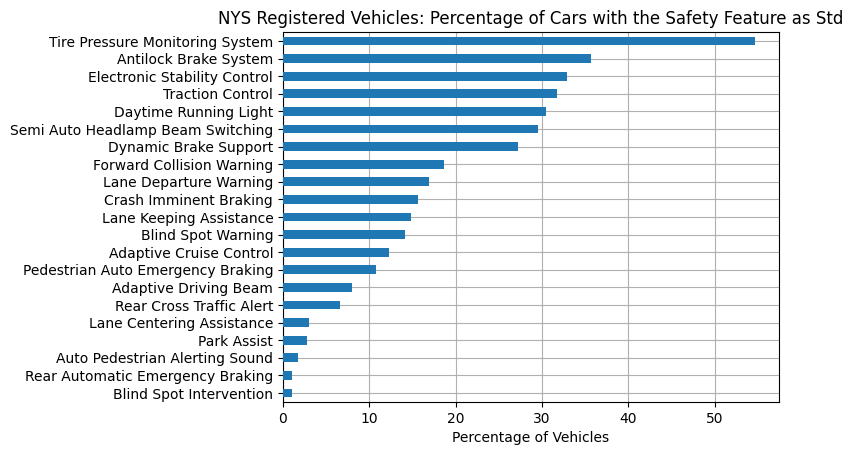

In [13]:
ax = vehSafetyFeaturesCnt.plot.barh(title="NYS Registered Vehicles: Percentage of Cars with the Safety Feature as Std",zorder=3)
ax.set_xlabel("Percentage of Vehicles")
ax.grid()